## Libraries

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

### Data proccesing

In [14]:
class ImagePairsDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_pairs = []
        self.labels = []
        self._load_data()

    def _load_data(self):
        for label in [0, 1]:
            label_dir = os.path.join(self.root_dir, str(label))
            for pair_dir in os.listdir(label_dir):
                pair_path = os.path.join(label_dir, pair_dir)
                if os.path.isdir(pair_path):
                    images = os.listdir(pair_path)
                    if len(images) == 2:
                        img1_path = os.path.join(pair_path, images[0])
                        img2_path = os.path.join(pair_path, images[1])
                        self.image_pairs.append((img1_path, img2_path))
                        self.labels.append(label)

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        img1_path, img2_path = self.image_pairs[idx]
        label = self.labels[idx]

        img1 = Image.open(img1_path).convert('RGB')
        img2 = Image.open(img2_path).convert('RGB')

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, torch.tensor(label, dtype=torch.float32)


In [15]:
transform = transforms.Compose([
    transforms.Resize((124, 124)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4411, 0.4411, 0.4411], std=[0.2432, 0.2432, 0.2432])
])

In [16]:
def train_val_test_split(dataset, train_size=0.7, val_size=0.15, test_size=0.15):
    assert train_size + val_size + test_size == 1
    train_val_indices, test_indices = train_test_split(range(len(dataset)), test_size=test_size)
    train_indices, val_indices = train_test_split(train_val_indices, test_size=val_size/(train_size + val_size))
    return train_indices, val_indices, test_indices

dataset = ImagePairsDataset(root_dir='./data', transform=transform)
train_indices, val_indices, test_indices = train_val_test_split(dataset)

train_sampler = Subset(dataset, train_indices)
val_sampler = Subset(dataset, val_indices)
test_sampler = Subset(dataset, test_indices)

train_loader = DataLoader(train_sampler, batch_size=32, shuffle=True)
val_loader = DataLoader(val_sampler, batch_size=32, shuffle=False)
test_loader = DataLoader(test_sampler, batch_size=32, shuffle=False)


## Model

In [17]:
class cCNN(nn.Module):
    def __init__(self):
        super(cCNN, self).__init__()
        self.conv1 = nn.Conv2d(6, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.fc1_input_dim = 128 * 15 * 15  # Zaktualizowane wymiary po trzech warstwach pool
        
        self.fc1 = nn.Linear(self.fc1_input_dim, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, img1, img2):
        x = torch.cat((img1, img2), dim=1)
        x = self.pool(self.bn1(torch.relu(self.conv1(x))))
        x = self.pool(self.bn2(torch.relu(self.conv2(x))))
        x = self.pool(self.bn3(torch.relu(self.conv3(x))))
        
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return self.sigmoid(x)
    
model = cCNN()

Epoch 1, Training Loss: 0.8871286982156241
Epoch 1, Validation Loss: 0.6251590641255075
Epoch 2, Training Loss: 0.6142849964677088
Epoch 2, Validation Loss: 0.5619416836728441
Epoch 3, Training Loss: 0.5738003318499385
Epoch 3, Validation Loss: 0.5303580717837557
Epoch 4, Training Loss: 0.5399146647732262
Epoch 4, Validation Loss: 0.5156654052277829
Epoch 5, Training Loss: 0.5221294839296088
Epoch 5, Validation Loss: 0.5476910290565896
Finished Training
Test Accuracy: 75.37%
Precision: 0.72
Recall: 0.83
F1 Score: 0.77


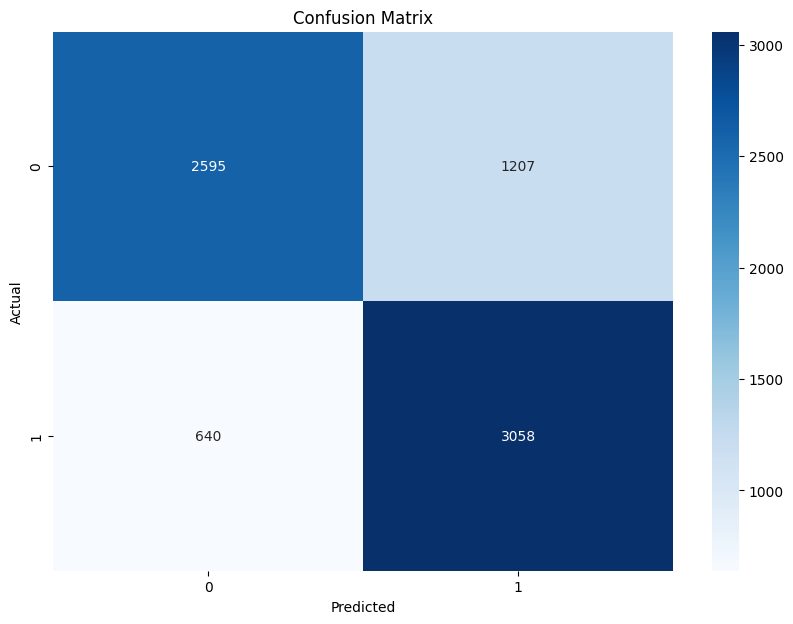

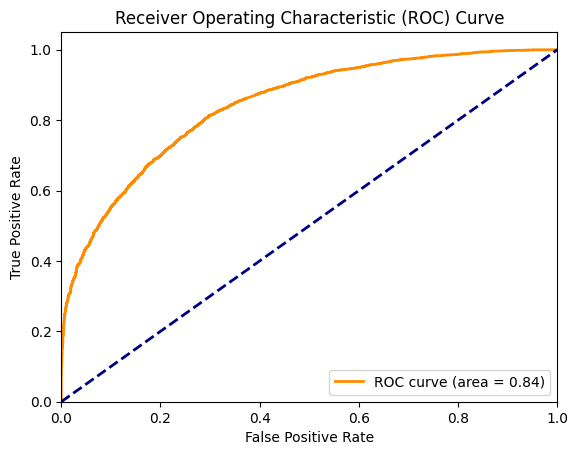

In [18]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for img1, img2, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(img1, img2)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch {epoch+1}, Training Loss: {running_loss/len(train_loader)}')

    # Walidacja
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for img1, img2, labels in val_loader:
            outputs = model(img1, img2)
            loss = criterion(outputs.squeeze(), labels)
            val_loss += loss.item()

    print(f'Epoch {epoch+1}, Validation Loss: {val_loss/len(val_loader)}')

print('Finished Training')
# model.load_state_dict(torch.load('cnn_model.pth'))
torch.save(model.state_dict(), 'simple_cnn_model.pth')
model.eval()
all_labels = []
all_predictions = []
all_probs = []

# Testing loop
with torch.no_grad():
    for img1, img2, labels in test_loader:
        outputs = model(img1, img2)
        probs = outputs.squeeze()
        predicted = (probs > 0.5).float()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

accuracy = np.mean(np.array(all_predictions) == np.array(all_labels))
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

print(f'Test Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

# Confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [19]:
model = cCNN()
model.load_state_dict(torch.load('simple_cnn_model.pth'))
model.eval()

img1_path = './moje/obraz1.jpg'
img2_path = './moje/obraz2.jpg'

img1 = Image.open(img1_path).convert('RGB')
img2 = Image.open(img2_path).convert('RGB')

img1 = transform(img1).unsqueeze(0)
img2 = transform(img2).unsqueeze(0)

with torch.no_grad():
    output = model(img1, img2)
    similarity = output.item() * 100  # Convert to percentage

print(f'The similarity between the two images is {similarity:.2f}%')

The similarity between the two images is 96.83%
